# 꽃 이미지 분류기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from PIL import Image
import gc

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = 'mps'

In [22]:
import pathlib

# 데이터 경로
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('./flower_photos', origin=dataset_url, untar=True) # untar=True -> 압축 풀기

# pathlib모듈 -> 파일의 경로를 객체로써 조작하거나 처리할 수 있다.
data_dir = pathlib.Path(data_dir)
print(data_dir)

/Users/kimhongseok/.keras/datasets/flower_photos


In [23]:
print(data_dir) # 데이터가 저장된 경로 확인

/Users/kimhongseok/.keras/datasets/flower_photos


### data 확인

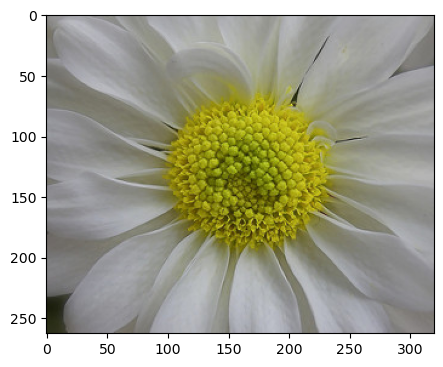

In [4]:
flower_img = Image.open('./flower_photos/daisy/100080576_f52e8ee070_n.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(flower_img)
plt.show()

# CustomDataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    # 데이터의 형태 정의 및 하나의 변수에 저장
    def __init__(self, root_dir, transform, classes):
        super().__init__()
        self.root_dir = root_dir # 이미지 데이터 기본 경로
        self.transform = transform # tensor형태로 변환하기 위한 함수
        self.classes = classes
        self.images = list()
        
        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            img_list = os.listdir(class_dir)
            for img in img_list:
                self.images.append((os.path.join(class_dir, img), label))

    # 데이터의 개수 반환
    def __len__(self):
        return len(self.images)
    
    # 특정 데이터 반환
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img_tmp = Image.open(img_path).convert('RGB')
        img = self.transform(img_tmp)
        return img, label

In [6]:
data_root_dir = './flower_photos'

transform = T.Compose([
    T.Resize((112, 112)), # 데이터 크기 축소
    T.ToTensor()
])

classes = os.listdir(data_root_dir)[:-1]

all_dataset = CustomDataset(data_root_dir, transform, classes)

In [7]:
print(classes)

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']


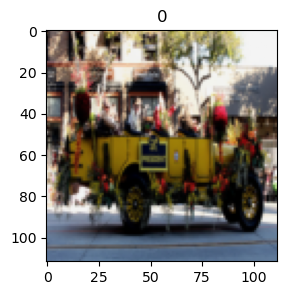

In [8]:
plt.figure(figsize=(3, 3))
plt.imshow(all_dataset[0][0].permute((1, 2, 0)))
plt.title(all_dataset[0][1])
plt.show()

In [9]:
# train, valid, test 구분
total_num = len(all_dataset)
print(total_num)
train_num, valid_num, test_num = int(total_num*0.5), int(total_num*0.2), int(total_num*0.3)

print(train_num, valid_num, test_num)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(all_dataset, [train_num, valid_num, test_num])

3670
1835 734 1101


### DataLoader

In [10]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [11]:
print(len(train_dataloader))

for images, labels in train_dataloader:
    print(len(images))
    print(images.shape)
    print(labels)
    break

19
100
torch.Size([100, 3, 112, 112])
tensor([1, 3, 0, 0, 0, 0, 1, 4, 3, 3, 1, 4, 0, 3, 2, 0, 4, 4, 4, 0, 2, 3, 2, 4,
        0, 4, 3, 1, 4, 2, 0, 3, 0, 1, 0, 0, 4, 2, 2, 4, 1, 1, 1, 1, 4, 0, 1, 0,
        4, 2, 0, 2, 0, 1, 2, 3, 1, 3, 3, 2, 0, 2, 4, 0, 2, 0, 3, 4, 3, 3, 4, 3,
        2, 4, 1, 3, 4, 4, 1, 3, 4, 1, 3, 3, 4, 4, 0, 0, 3, 1, 4, 4, 0, 0, 4, 2,
        0, 4, 0, 4])


# Model 생성

In [12]:
class CNN_v1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=112*112*32, out_features=1024),
            torch.nn.Linear(in_features=1024, out_features=5),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [13]:
model_test = CNN_v1()
summary(model_test, input_size=(3, 112, 112))

del model_test
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              ReLU-3         [-1, 16, 112, 112]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8         [-1, 32, 112, 112]               0
           Flatten-9               [-1, 401408]               0
           Linear-10                 [-1, 1024]     411,042,816
           Linear-11                    [-1, 5]           5,125
       LogSoftmax-12                    [-1, 5]               0
Total params: 411,053,125
Trainable params: 411,053,125
Non-trainable params: 0
-----------------------

2827

# train, eval 함수

In [14]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0
    
    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (labels == predicted).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        print(epoch + 1)
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        if early_stop_cnt >= 10:
            break

    return model

In [15]:
model1 = CNN_v1()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

model = training_loop(model1, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 200)

1


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 547.1029939651489, Train Accuracy: 0.3536784741144414
Valid Loss: 260.45710945129395, Valid Accuracy: 0.2329700272479564
2


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 98.29252423738178, Train Accuracy: 0.5247956403269755
Valid Loss: 54.1285457611084, Valid Accuracy: 0.5068119891008175
3


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 44.2082472349468, Train Accuracy: 0.5416893732970027
Valid Loss: 50.156713008880615, Valid Accuracy: 0.47411444141689374
4


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 23.23904218171772, Train Accuracy: 0.6059945504087193
Valid Loss: 25.79596996307373, Valid Accuracy: 0.5163487738419619
5


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 15.562702480115389, Train Accuracy: 0.644141689373297
Valid Loss: 24.274149656295776, Valid Accuracy: 0.49182561307901906
6


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 12.313821867892617, Train Accuracy: 0.6801089918256131
Valid Loss: 20.822511196136475, Valid Accuracy: 0.5326975476839237
7


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 6.717632331346211, Train Accuracy: 0.7160762942779292
Valid Loss: 17.220975160598755, Valid Accuracy: 0.510899182561308
8


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 4.993041709849709, Train Accuracy: 0.7662125340599455
Valid Loss: 13.353715181350708, Valid Accuracy: 0.5653950953678474
9


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 2.8773322607341565, Train Accuracy: 0.8163487738419618
Valid Loss: 13.725174307823181, Valid Accuracy: 0.5204359673024523
10


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 2.213108768588618, Train Accuracy: 0.8310626702997275
Valid Loss: 12.913975954055786, Valid Accuracy: 0.5054495912806539
11


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 5.064409610472228, Train Accuracy: 0.7542234332425068
Valid Loss: 16.712082505226135, Valid Accuracy: 0.4904632152588556
12


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 2.8238739120332816, Train Accuracy: 0.8223433242506812
Valid Loss: 12.260053873062134, Valid Accuracy: 0.5190735694822888
13


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.8590077773520821, Train Accuracy: 0.828882833787466
Valid Loss: 10.698369443416595, Valid Accuracy: 0.5286103542234333
14


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 2.3234214100398516, Train Accuracy: 0.8190735694822888
Valid Loss: 10.556519627571106, Valid Accuracy: 0.5463215258855586
15


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 2.3979282692859045, Train Accuracy: 0.8114441416893733
Valid Loss: 12.649189233779907, Valid Accuracy: 0.4986376021798365
16


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.991923595729627, Train Accuracy: 0.8299727520435968
Valid Loss: 13.783881783485413, Valid Accuracy: 0.5040871934604905
17


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 1.3445998602791835, Train Accuracy: 0.8577656675749319
Valid Loss: 9.25432962179184, Valid Accuracy: 0.5217983651226158
18


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.6279204464272449, Train Accuracy: 0.9073569482288828
Valid Loss: 10.24474948644638, Valid Accuracy: 0.5367847411444142
19


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 0.5660240559985763, Train Accuracy: 0.9177111716621253
Valid Loss: 8.037053525447845, Valid Accuracy: 0.5599455040871935
20


  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

# test

In [68]:
model.to(device)
model.eval()

test_loss = 0.0
test_accuracy = 0

total_images = []
total_labels = []
total_outputs = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_outputs.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss, test_accuracy)

  0%|          | 0/12 [00:00<?, ?it/s]

6.605663537979126 0.46139872842870117


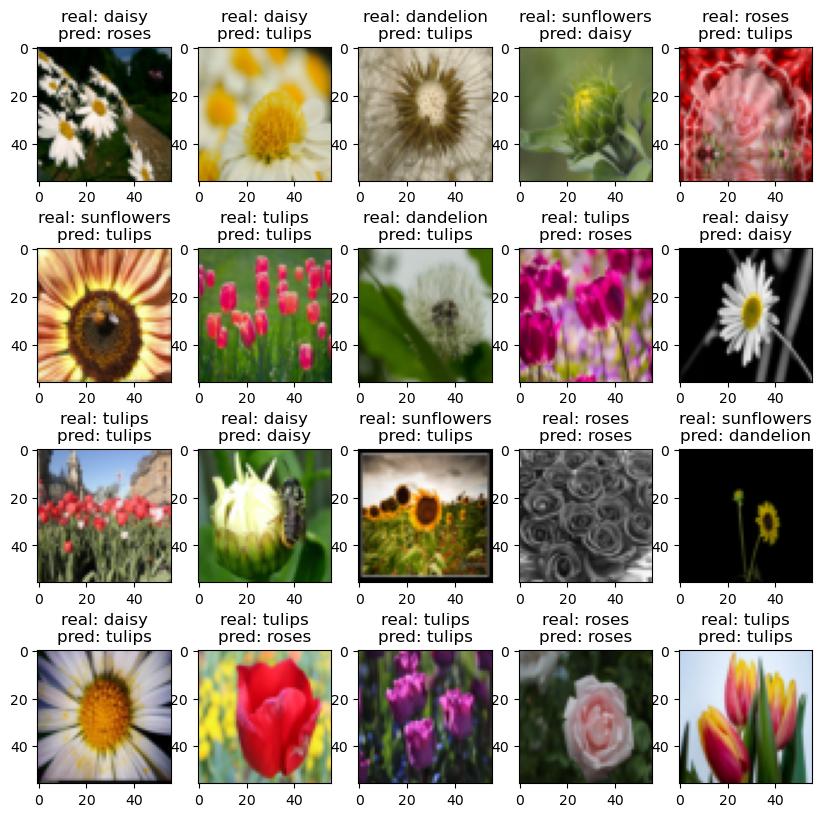

In [70]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_images[i].cpu().permute(1, 2, 0))
    plt.title(f'real: {classes[total_labels[i].cpu()]}\npred: {classes[total_outputs[i].cpu()]}')

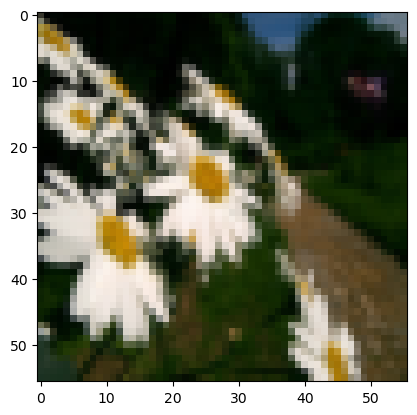

In [66]:
plt.imshow(total_images[0].cpu().permute(1, 2, 0))